In [84]:
from algorithm import WeightEstimator

In [85]:
from sklearn.mixture import GaussianMixture
import numpy as np
from scipy.stats import multivariate_normal

In [86]:
n_samples = 500

# Generate random sample, two components
np.random.seed(0)
C = np.array([[0., -0.1], [1.7, .4]])
X = np.r_[np.dot(np.random.randn(n_samples, 2), C),
          .7 * np.random.randn(n_samples, 2) + np.array([-6, 3])]


In [87]:
densities =[]
for x in np.linspace(-10,10,20):
    for y in np.linspace(-10,10,20):
        for var in [5, 1, 1e-1]:
            densities.append(multivariate_normal([x,y], var*np.diag([1,1])))

In [88]:
cl = WeightEstimator(densities_dict=densities, select_threshold=1e-2)
cl.fit(X)

In [89]:
res = cl.select_densities()
res

[(218, 0.06889282692661267),
 (221, 0.035466544430183496),
 (277, 0.10231750989867713),
 (278, 0.1456275319223059),
 (281, 0.10825819703086038),
 (338, 0.01906926295800231),
 (449, 0.04082022119365628),
 (509, 0.07447416210326328),
 (569, 0.126301475765866),
 (632, 0.1256061852841631),
 (692, 0.06665509095610522),
 (752, 0.037483876841484486),
 (812, 0.01421875846189462)]

In [90]:
densities[568].cov

array([[ 1.,  0.],
       [ 0.,  1.]])

In [91]:
%matplotlib inline

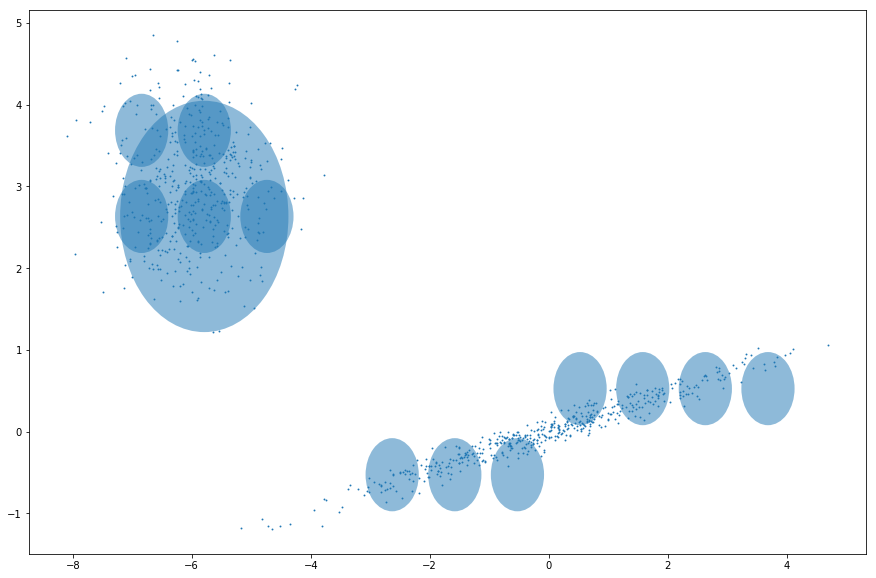

In [92]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import linalg
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10
splot = plt.subplot(1, 1, 1)

splot.scatter(X[:,0],X[:,1], .8)
for i,_ in res:
    d = densities[i]
    mean, covar = d.mean, d.cov
    v, w = linalg.eigh(covar)
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    u = w[0] / linalg.norm(w[0])
    # Plot an ellipse to show the Gaussian component
    angle = np.arctan(u[1] / u[0])
    angle = 180. * angle / np.pi  # convert to degrees
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle)
    ell.set_alpha(0.5)
    splot.add_artist(ell)

In [93]:
gmm = GaussianMixture(20)
gmm.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=20, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [94]:
densities =[]
for mean, var in zip(gmm.means_, gmm.covariances_):
    densities.append(multivariate_normal(mean, var))

In [95]:
cl = WeightEstimator(densities_dict=densities, select_threshold=1e-3)
cl.fit(X)

In [96]:
w = cl.select_densities()

In [97]:
#On va essayer de faire une grille de l'espace et faire tourner EM et kde sur chaque portion
#pour construire le dictionaire


In [98]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X0 = sc.fit_transform(X)

In [203]:
k_em = 2
x_min, x_max, y_min, y_max = X0[:,0].min(), X0[:,0].max(), X0[:,1].min(), X0[:,1].max()
x_steps = np.linspace(x_min, x_max, grid_length)
y_steps = np.linspace(y_min, y_max, grid_length)
densities_dictionary = []
for grid_length in [5]:
    for idx, x_step in enumerate(x_steps[:-1]):
        for idy, y_step in enumerate(y_steps[:-1]):
            X_temp = X0[(X0[:,0] > x_step) & (X0[:,0] < x_steps[idx+1]) & (X0[:,1] > y_step) & (X0[:,1] < y_steps[idy+1]) ]
            if X_temp.shape[0] > k_em:
                gmm = GaussianMixture(3)
                gmm.fit(X_temp)
                for mean, var in zip(gmm.means_, gmm.covariances_):
                    densities_dictionary.append(multivariate_normal(mean, var))

In [204]:
cl = WeightEstimator(densities_dict=densities_dictionary, select_threshold=1e-10)

In [205]:
cl.fit(X)

In [206]:
res = cl.select_densities()

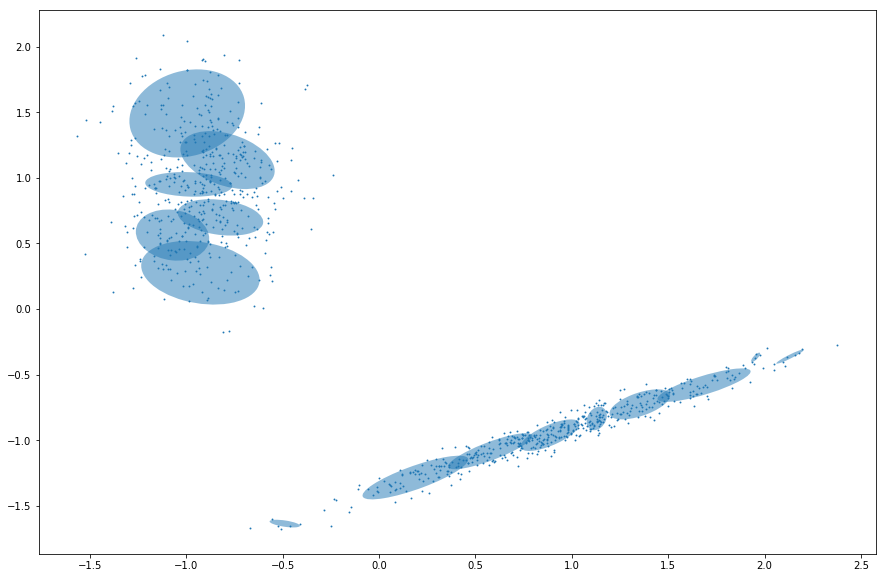

In [270]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import linalg
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10
splot = plt.subplot(1, 1, 1)

splot.scatter(X0[:,0],X0[:,1], .8)
for i,_ in res:
    d = densities_dictionary[i]
    mean, covar = d.mean, d.cov
    v, w = linalg.eigh(covar)
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    u = w[0] / linalg.norm(w[0])
    # Plot an ellipse to show the Gaussian component
    angle = np.arctan(u[1] / u[0])
    angle = 180. * angle / np.pi  # convert to degrees
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle)
    ell.set_alpha(0.5)
    splot.add_artist(ell)

In [266]:
best_bic = 1e10
for k in range(2,50):
    gmm = GaussianMixture(k)
    gmm.fit(X0)
    bic = gmm.bic(X0)
    if bic < best_bic:
        best_bic = bic
        score = gmm.score(X0)
        print score
        best_bic_param = (bic, score, gmm.covariances_, gmm.means_, gmm.weights_)
    

-0.593958426083


In [218]:
best_bic_param

(1263.902160235305, -0.59395842608325078, array([[[ 0.04419145, -0.00167405],
         [-0.00167405,  0.17657536]],
 
        [[ 0.27511103,  0.13111519],
         [ 0.13111519,  0.06617231]]]), array([[-0.91670593,  0.93735114],
        [ 0.91670593, -0.93735114]]), array([ 0.5,  0.5]))

In [222]:
densities_em = []
for cov, mean in zip(best_bic_param[2], best_bic_param[3]):
    densities_em.append(multivariate_normal(mean, cov))


In [246]:
X, Y = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
X_grid = np.vstack([X.ravel(), Y.ravel()]).T
X_grid

array([[-1.56823698, -1.67710096],
       [-1.56823698, -1.6390663 ],
       [-1.56823698, -1.60103165],
       ..., 
       [ 2.3773    ,  2.01226036],
       [ 2.3773    ,  2.05029501],
       [ 2.3773    ,  2.08832966]])

In [267]:
def f(x):
    fk = np.array([d.pdf(x) for d in densities_em])
    return best_bic_param[-1].dot(fk)
f_em = np.apply_along_axis(f, 1, X0)
print np.log(f_em).sum()/X0.shape[0]

-0.593958426083


In [268]:
selected_densities_estim, weights_estim = np.array(zip(*res))
f_weight_estim = np.apply_along_axis(lambda x: weights_estim.dot(np.array([densities_dictionary[i].pdf(x) for i in selected_densities_estim.astype(int)])), 1, X0)
log_lik = np.log(f_weight_estim).sum()/X0.shape[0]
log_lik

-8.3712067081521084

In [269]:
res

[(0, 2.468445315386651e-06),
 (1, 2.468445315386651e-06),
 (2, 2.468445315386651e-06),
 (3, 2.4684443860283276e-06),
 (4, 0.9999523473247092),
 (5, 2.4683833130257814e-06),
 (6, 2.4684452945443565e-06),
 (7, 2.4684445357222458e-06),
 (8, 2.4684453153866236e-06),
 (9, 2.4684453153866393e-06),
 (10, 2.468445315386627e-06),
 (11, 2.468445315386679e-06),
 (12, 2.468445315386649e-06),
 (13, 2.4684453153866465e-06),
 (14, 2.4684453153866203e-06),
 (15, 2.468445315386651e-06),
 (16, 2.4684453153866325e-06),
 (17, 2.468445315386651e-06)]